<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1313384"><< Back to FutureLearn</a><br>

# Tile-based classification using Sentinel-2 L1C and EuroSAT data - Inference

<i>by Nicolò Taggio, Planetek Italia S.r.l., Bari, Italy</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/636104150?h=ae18192afe" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<br>

<hr>

## Introduction

This notebook is the second notebook of the `tile-based classification with EuroSAT data` workflow and guides you through the process of `inference`. `Inference` is the process where the learned capabilities of a pre-trained model are put into practise and are applied to a Sentinel-2 Level-1C scene. 

The notebook [3B_tile-based_classification_with_EuroSAT_data_training](./3B_tile-based_classification_with_EuroSAT_data_training.ipynb) is the first step and guides you through training a convolutional neural network based on EuroSAT benchmark data for land use / land cover classification.

This notebook guides you through the preparation of a Sentinel-2 Level-1C tile for the inference process, loads the pre-trained model and executes the inference process, which 'infers' land cover classes based on the pre-trained model and the Sentinel-2 L1C tile as input. 

## Data

The inference process makes use of the following data:
* a `Sentinel-2 Level-1C file`, which is available under the folder [./S2_Tile_based_classification/01_input_data/S2_tile_4_inference](./S2_Tile_based_classification/01_input_data/S2_tile_4_inference/). The scene shows a coastal part over Italy on 31 March 2021. The scence is used as input data for the pretrained model in order to 'infer' land use / land cover classes.
* a `pretrained model`, a `convolutional neural network` which has been trained based on EuroSAT data, a benchmark dataset for land use / land cover classifications.

## Further resources

* [3B - Tile-based classification with EuroSAT data - Training](./3B_tile-based_classification_with_EuroSAT_data_training.ipynb)
* [EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification](https://arxiv.org/abs/1709.00029)
* [EuroSAT data](https://github.com/phelber/eurosat)

<hr>

## Notebook outline
* [1 - Load a Sentinel-2 Level-1C tile](#load_s2l1_inference)
* [2 - Resample all bands of a Sentinel-2 Level-1C tile to 10m spatial resolution](#resample_inference)
* [3 - Reorder the bands according to the order of the pretrained model](#reorder_inference)
* [4 - Load the pretrained sequential convolutional neural network based on EuroSAT data](#load_model_inference)
* [5 - Divide the Sentinel-2 L1C tile into 64x64 windows](#windows_inference)
* [6 - Inference of land use classes](#inference_step)
* [7 - Visualize the final classified image](#visualize_inference)

<hr>

#### Import libraries

In [2]:
## BEGIN S3FS IMPORT SNIPPET ##
import os, sys
s3_home =  os.getcwd()
try: sys.path.remove(s3_home) # REMOVE THE S3 ROOT FROM THE $PATH
except Exception: pass

current_dir = os.getcwd()

os.chdir('/home/jovyan') # TEMPORARILY MOVE TO ANOTHER DIRECTORY

# BEGIN IMPORTS #
import tensorflow as tf
from osgeo import gdal_array, osr, gdal
import glob
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.colors

import warnings
warnings.filterwarnings("ignore")
# END IMPORTS #

os.chdir(current_dir) # GO BACK TO YOUR PREVIOUS DIRECTORY

sys.path.append(s3_home) # RESTORE THE S3 ROOT IN THE $PATH

## END S3FS IMPORT SNIPPET ##

#### Load helper functions

In [3]:
%run ./3B_tile-based_classification_with_EuroSAT_data_functions.ipynb

<hr>

<br>

## <a id='load_s2l1_inference'></a>1. Load a Sentinel-2 Level-1C tile

The first step is to load the input data for the inference process. The input data is a Sentinel-2 Level-1C tile which shall be classified with the help of the pre-trained model.

Let us define a Python dictionary which holds information about where the Sentinel-2 Level-1C data is stored. Define `main_path`, `sentinel2_safe_name` and `sentinel2_safe_path`.

In [4]:
data_input = {}
data_input['main_path'] ='./S2_Tile_based_classification/'

data_input['sentinel2_safe_name'] ='S2A_MSIL1C_20210331T100021_N0300_R122_T33TTG_20210331T113321.SAFE/'
data_input['sentinel2_safe_path'] = data_input['main_path']+'01_Input_data/S2_tile_4_inference/' + data_input['sentinel2_safe_name']

<br>

The next step makes use of the function [from_folder_to_stack()](./3B_tile-based_classification_with_EuroSAT_data_functions.ipynb#from_folder_to_stack). The functions transforms the Sentinel-2 Level-1C file which is disseminated in the `.SAFE` format into three different arrays, each combining the bands with the same spatial resolution. Sentinel-2 samples 13 spectral bands, which have three different resolutions: `10m, 20m and 60m`.

The result of the function are three stacked arrays:
* `stack_10m`: stack combining bands with 10m spatial resolution `(B02, B03, B04, B08)`
* `stack_20m`: stack combining bands with 20m spatial resolution `(B05, B06, B07, B11, B12, B8A)`
* `stack_60m`: stack combining bands with 60m spatial resolution `(B01, B09, B10)`

**Note:** you can open the doc string of the function with `?from_folder_to_stack`, which informs you about the aim of the function as well as input and output arguments.

In [5]:
safe_path = data_input['sentinel2_safe_path']
stack_10m, stack_20m, stack_60m = from_folder_to_stack(safe_path)

[AI4EO_MOOC]_log: Loading .jp2 images in ./S2_Tile_based_classification/01_Input_data/S2_tile_4_inference/S2A_MSIL1C_20210331T100021_N0300_R122_T33TTG_20210331T113321.SAFE/GRANULE/L1C_T33TTG_A030149_20210331T100404/IMG_DATA/
[AI4EO_MOOC]_log: Reading .jp2 files in ./S2_Tile_based_classification/01_Input_data/S2_tile_4_inference/S2A_MSIL1C_20210331T100021_N0300_R122_T33TTG_20210331T113321.SAFE/GRANULE/L1C_T33TTG_A030149_20210331T100404/IMG_DATA/
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B01.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B02.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B03.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B04.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B05.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B06.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B07.jp2
[AI4EO_MOOC]_log: Using .jp2 image: T33TTG_20210331T100021_B08.jp2
[AI4EO_MOOC]_lo

<br>

If you inspect the dimensions of the three stacked arrays, you see that the stack combining bands with 10m resolution consists of 4 bands, the one combining bands with 20m resolution consists of 6 bands and the one combining bands with 60m resolution consists of 3 bands.

In [6]:
print(stack_10m.shape)
print(stack_20m.shape)
print(stack_60m.shape)

(10980, 10980, 4)
(5490, 5490, 6)
(1830, 1830, 3)


<br>

## <a id='resample_inference'></a>2. Resample all bands of a Sentinel-2 Level-1C tile to 10m spatial resolution

The next step is to resample the arrays containing bands with 20m and 60m resolution to a 10m spatial resolution. You can use the function [resample_3d()](./3B_tile-based_classification_with_EuroSAT_data_functions.ipynb#resample_3d) to do this. The function takes the following keyword arguments:
* `stack`: array to be resampled to 10m
* `row10m`: number of rows of the 10m resolution array
* `col10m`: number of columns of the 10m resolution array
* `rate`: to which rate the input stack shall be resampled

You have to apply the function to both array stacks, `stack_20m` and `stack_60m`. The result is that all three array stacks have the same spatial resolution (10m).

In [7]:
n_row, n_col, b10 = stack_10m.shape

print('[AI4EO_MOOC]_log: Resampling stack with 20 m pixel size...')
stack_20mTo10m = resample_3d(stack = stack_20m,
                             row10m = n_row,
                             col10m = n_col,
                             rate = 2)

print('[AI4EO_MOOC]_log: Resampling stack with 60 m pixel size...')
stack_60mTo10m = resample_3d(stack = stack_60m,
                             row10m = n_row,
                             col10m = n_col,
                             rate= 6)

print(stack_20mTo10m.shape)
print(stack_60mTo10m.shape)


[AI4EO_MOOC]_log: Resampling stack with 20 m pixel size...
[AI4EO_MOOC]_log: Array shape (5490,5490,6)
[AI4EO_MOOC]_log: Resize array bands from (5490,5490,6) to (10980,10980,6)
[AI4EO_MOOC]_log: Resampling stack with 60 m pixel size...
[AI4EO_MOOC]_log: Array shape (1830,1830,3)
[AI4EO_MOOC]_log: Resize array bands from (1830,1830,3) to (10980,10980,3)
(10980, 10980, 6)
(10980, 10980, 3)


<br>

## <a id='reorder_inference'></a>3. Reorder the bands according to the order of the pretrained model

The three array stacks have now the same spatial resolution. In a next step, you can concatenate them with the numpy function `concatenate`. You want to contatenate them on the band dimensions (axis=2). The result is one single array with a spatial resolution of 10m and 13 bands.

In [8]:
print('[AI4EO_MOOC]_log: Creating multistack with 10-20-60 m pixel size')

total_stack=np.concatenate((stack_10m, stack_20mTo10m, stack_60mTo10m), 
                           axis=2)

total_stack.shape

[AI4EO_MOOC]_log: Creating multistack with 10-20-60 m pixel size


(10980, 10980, 13)

<br>

You can now plot the reflectance for each band for one pixel with matplotlib's `plot()` function.

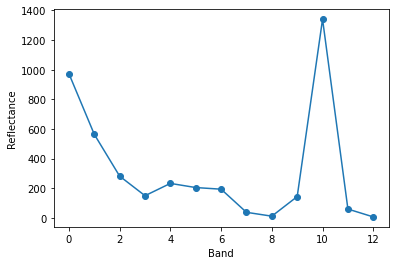

In [9]:
plt.ylabel("Reflectance")
plt.xlabel('Band')
plt.plot(total_stack[200,200,:],'-o')

<br>

The next step is to arrange the Sentinel-2 bands and bring them to the correct position for the pre-trained model. The function [sentinel2_format](./3B_tile-based_classification_with_EuroSAT_data_functions.ipynb#sentine2_format) helps you to bring the bands into the correct order for the model. You want to arrange the bands into the following order:
* `Band 1 – Coastal aerosol` <-- `S2L1 Band 10`
* `Band 2 – Blue` <-- `S2L1 Band 0`
* `Band 3 – Green` <-- `S2L1 Band 1`
* `Band 4 – Red` <-- `S2L1 Band 2`
* `Band 5 – Vegetation red edge` <-- `S2L1 Band 4`
* `Band 6 – Vegetation red edge` <-- `S2L1 Band 5`
* `Band 7 – Vegetation red edge` <-- `S2L1 Band 6`
* `Band 8 – NIR` <-- `S2L1 Band 3`
* `Band 8A – Narrow NIR` <-- `S2L1 Band 9`
* `Band 9 – Water vapour` <-- `S2L1 Band 11`
* `Band 10 – SWIR – Cirrus` <-- `S2L1 Band 12`
* `Band 11 – SWIR` <-- `S2L1 Band 7`
* `Band 12 – SWIR` <-- `S2L1 Band 8`



In [10]:
s2_arr = sentinel2_format(total_stack)


[AI4EO_MOOC]_log: Creating total stack with following bands list:
[AI4EO_MOOC]_log: Band 1 – Coastal aerosol
[AI4EO_MOOC]_log: Band 2 – Blue
[AI4EO_MOOC]_log: Band 3 – Green
[AI4EO_MOOC]_log: Band 4 – Red
[AI4EO_MOOC]_log: Band 5 – Vegetation red edge
[AI4EO_MOOC]_log: Band 6 – Vegetation red edge
[AI4EO_MOOC]_log: Band 7 – Vegetation red edge
[AI4EO_MOOC]_log: Band 8 – NIR
[AI4EO_MOOC]_log: Band 8A – Narrow NIR
[AI4EO_MOOC]_log: Band 9 – Water vapour
[AI4EO_MOOC]_log: Band 10 – SWIR – Cirrus
[AI4EO_MOOC]_log: Band 11 – SWIR
[AI4EO_MOOC]_log: Band 12 – SWIR


<br>

Now, you can plot the reflectance for each of the bands for the same pixel as above and you can now easier identify it as a water pixel.

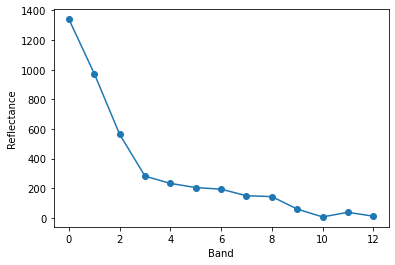

In [11]:
plt.ylabel("Reflectance")
plt.xlabel('Band')
plt.plot(s2_arr[200,200,:],'-o')

<br>

You can also plot the reflectances of another pixel and see higher reflectances over bands 6 to 8, which are the channels for vegetation.

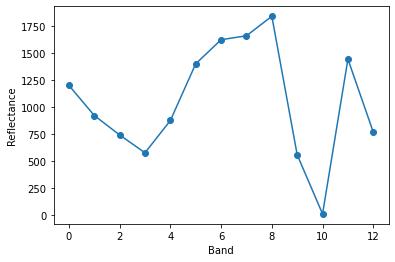

In [12]:
plt.ylabel("Reflectance")
plt.xlabel('Band')
plt.plot(s2_arr[10000,10000,:],'-o')

<br>

## <a id='load_model_inference'></a>4. Load the pre-trained sequential convolutional neural network based on EuroSAT data

Next, you can load the pre-trained model which has been trained in the notebook [3B_tile-based_classification_with_EuroSAT_data_training](./3B_tile-based_classification_with_EuroSAT_data_training.ipynb). The function `load_model()` from the class `keras.models` allows you to load a model in the Keras format `H5`. With `model.summary()` you can get tabular overview of the model architecture.

In [13]:
data_input['pre_trained_model_name'] = 'keras_sentinel2_classification_trained_model_e50_9190.h5'
data_input['pre_trained_model_path'] = data_input['main_path']+'02_pretrained_model/'

model = tf.keras.models.load_model(data_input['pre_trained_model_path'] + data_input['pre_trained_model_name'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        3776      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)       

<br>

## <a id='windows_inference'></a>5. Divide the Sentinel-2 L1C tile into 64x64 windows

Since the Convolutional Neural Network has been trained on the EuroSAT benchmark data, which have a dimension of `[13, 64, 64]`, the trained model can only predict on `64x64 pixel` subsets (so-called chips).

You can apply the function [sliding()](./3B_tile-based_classification_with_EuroSAT_data_functions.ipynb#sliding), which divides the Sentinel-2 image with a dimension of `10980 x 10980 pixels` into multiple subsets with the size of `64 x 64 pixels`.

In [14]:
print('[AI4EO_MOOC]_log: Divide all image into windows for inference step')

target_shape = (s2_arr.shape[0], s2_arr.shape[1])
windows = sliding(target_shape, 64, fixed=True)


[AI4EO_MOOC]_log: Divide all image into windows for inference step


<br>

## <a id='inference_step'></a>6. Inference of land use classes

The next step is the inference process, which applies the loaded model and predicts the probabilites of each of the ten land use classes for each pixel. First, let us define some variables that help us to specify the inference process. Let us define `batch_size=10`, which specifies the number of parallel computations and which also reduces the number of iterations during the inference process by a factor of 10.

In [15]:
windows_ = iter(windows)
windows_class = iter(windows)

batch_size = 10
total_chips = len(windows)
num_steps = int(total_chips / batch_size)

<br>

The next step goes through each `64 x 64 pixel` window (chip), retrieves the channel information of the Sentinel-2 image and predicts the land cover classes for each chip with the function `model.predict()`.
The prediction result returns the probability of each land use class for each pixel. With the numpy function `argmax()`, you can select the class with the highest predicted probability.

The last step is to gradually build up the final image `img_classes` with the predicted land use classes and a dimension of `(10980, 10980)`, based on the `64 x 64 pixel` windows.

In [16]:
print('[AI4EO_MOOC]_log: Inference step...')

img_classes = np.zeros((total_stack.shape[0], total_stack.shape[1]), dtype=np.uint8)


predictions = []
progbar = tf.keras.utils.Progbar(num_steps)

for b in range(num_steps):
    chips = np.empty([batch_size, 64, 64, 13])
    for k in range(batch_size):
        ymin, xmin, xmax, ymax = next(windows_)
        chips[k] = s2_arr[xmin:xmin+xmax, ymin:ymin+ymax, :]        
    
    preds = model.predict(chips)
    predictions.append(np.argmax(preds, axis=-1))
    for i in range(0, batch_size):
        ymin_cl, xmin_cl, xmax_cl, ymax_cl = next(windows_class)
        img_classes[xmin_cl:xmin_cl+xmax_cl, ymin_cl:ymin_cl+ymax_cl] = predictions[b][i]
    progbar.update(b + 1)

[AI4EO_MOOC]_log: Inference step...
2924/2924 [==============================] - 136s 46ms/step


<br>

## <a id='visualize_inference'></a>7. Visualize the final classified image

The last step is to visualize the classified image after the inference step. You can use matplotlib's function `imshow()` to visualize the predicted array `img_classes`. For readability, you can define class labels (`label`) and a customized color scale.

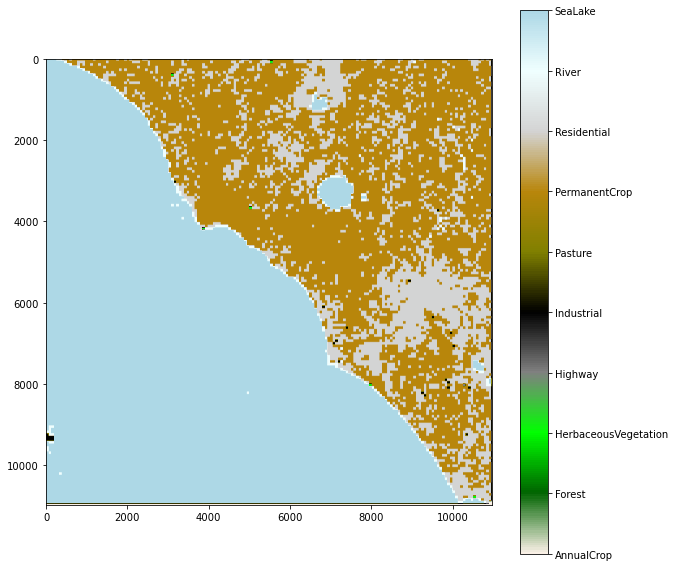

In [17]:
label=['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial',
       'Pasture','PermanentCrop','Residential','River','SeaLake']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", 
    ["linen","darkgreen","lime","grey","k",
     "olive","darkgoldenrod","lightgrey","azure","lightblue"])

plt.figure(figsize=(10,10))
plt.imshow(img_classes, cmap=cmap)
cbar=plt.colorbar()
cbar.ax.set_yticklabels(label)
plt.show()

<br>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1170903"><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
